In [2]:
%%capture
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from time import time

2025-12-02 14:34:23.621303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-02 14:34:23.621384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-02 14:34:23.623459: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-02 14:34:23.635380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
device="CPU"

## Attaques untargeted

In [4]:
def fgsm_attack(model, loss_fn, images, labels, epsilon):
    with tf.device(f'/{device}:0'): # préciser ce qu'on utilise (CPU/GPU)

        # convertir en array format tensorflow
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        labels = tf.convert_to_tensor(labels, dtype=tf.float32)
        
        with tf.GradientTape() as tape: # On se penche sur chaque chose qui se passe dans ce block, tout est 'enregistré'
            tape.watch(images) # preter attention aux images: l'idée est de voir comment les images actuelles impactent le résultat final
            outputs = model(images) # faire tourner le modele sur les images et stocker le resultat
            cost = loss_fn(labels, outputs) # calculer le loss obtenu (petit loss=model fort sur cette image)
        
        gradients = tape.gradient(cost, images) # le fameux gradient, a priori ça donne les pixels les + responsables de l'augmentation du loss (donc ceux sur lesquels on se focus pour en changer le moins mais être le plus efficace)
        
        attack_images = images + epsilon * tf.sign(gradients) # augmenter ces pixels d'un facteur epsilon et dans le bon sens (d'où la fonction sign)
        attack_images = tf.clip_by_value(attack_images, 0, 1) # si un pixel est sorti de [0, 1], on le remet dans [0, 1]
        
        return attack_images.numpy()

In [5]:
loss_fn = tf.keras.losses.CategoricalCrossentropy() # loss utilise dans train_model.ipynb
model = tf.keras.models.load_model('/work/mnist_classifier_model.keras')

2025-12-02 14:34:31.244747: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (34)


In [6]:
epsilon = 0.2  # [0, 1]
# charger les donnees mnist 
n = 3  # nombre d'images affichées
batch_size = 32
(_, _), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
test_images = test_images.astype('float32') / 255.0 # normaliser
test_labels = to_categorical(test_labels, 10) # categorical, on stocke [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] au lieu de 5
normal_loader = tf.data.Dataset.from_tensor_slices((test_images[:n*batch_size], test_labels[:n*batch_size])).batch(batch_size)

total = 0
correct = 0
adv_images_list = []
predictions_list = []
confidences_list = []
true_labels_list = []

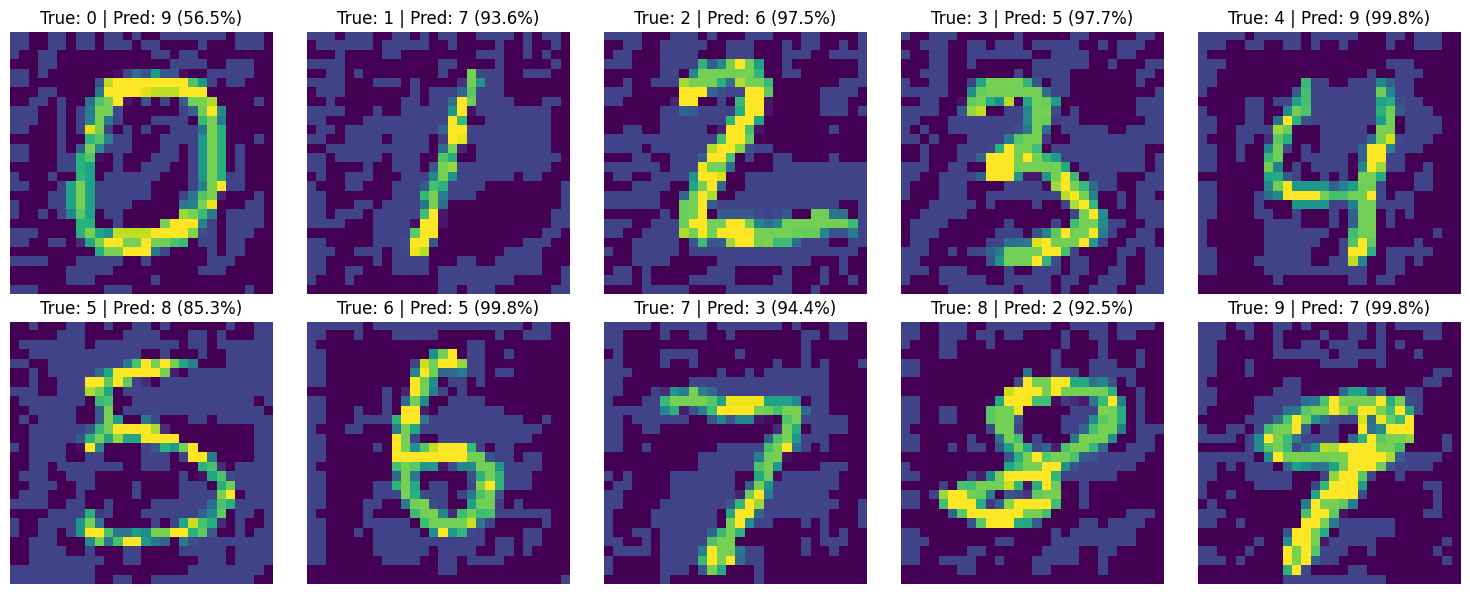

Accuracy of test text: 1.041667 %


In [7]:


for images, labels in normal_loader:
    attack_images = fgsm_attack(model, loss_fn, images, labels, epsilon)
    outputs = model(attack_images)
    
    predictions = np.argmax(outputs, axis=1)
    confidences = np.max(outputs, axis=1) * 100
    true_labels = np.argmax(labels, axis=1)
    
    total += len(labels)
    correct += np.sum(predictions == true_labels)
    
    # Store for display
    adv_images_list.extend(attack_images)
    predictions_list.extend(predictions)
    confidences_list.extend(confidences)
    true_labels_list.extend(true_labels)

# grille 2*5
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

display_images = [  adv_images_list[10], # 0
                    adv_images_list[2], # 1
                    adv_images_list[1], # 2
                    adv_images_list[32], # 3
                    adv_images_list[4], # 4
                    adv_images_list[15], # 5
                    adv_images_list[21], # 6
                    adv_images_list[0], # 7
                    adv_images_list[61], # 8
                    adv_images_list[9]] # 9


display_confidences = [confidences_list[10],
                       confidences_list[2],
                       confidences_list[1],
                       confidences_list[32],
                       confidences_list[4],
                       confidences_list[15],
                       confidences_list[21],
                       confidences_list[0],
                       confidences_list[61],
                       confidences_list[9]]

display_predictions = [predictions_list[10],
                       predictions_list[2],
                       predictions_list[1],
                       predictions_list[32],
                       predictions_list[4],
                       predictions_list[15],
                       predictions_list[21],
                       predictions_list[0],
                       predictions_list[61],
                       predictions_list[9]]

for i in range(10):
    axes[i].imshow(display_images[i].reshape(28, 28))
    axes[i].set_title(f'True: {i} | Pred: {display_predictions[i]} ({display_confidences[i]:.1f}%)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

In [8]:
img = test_images[0].reshape(1,28,28)
lab = test_labels[0].reshape(1,10)
%timeit fgsm_attack(model, loss_fn, img, lab, epsilon)

19 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
epsilon_vals=[]
accuracy=[]
for epsilon in range(30):

    total=0
    correct=0
    
    for images, labels in normal_loader:
    
        attack_images = fgsm_attack(model, loss_fn, images, labels, epsilon/100)
        outputs = model(attack_images)
        
        predictions = np.argmax(outputs, axis=1)
        
        total += len(labels)
        correct += np.sum(predictions == np.argmax(labels, axis=1))

    epsilon_vals.append(epsilon/100)
    accuracy.append(100 - 100*correct/total)
    

/tmp/ipykernel_259/3294195966.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


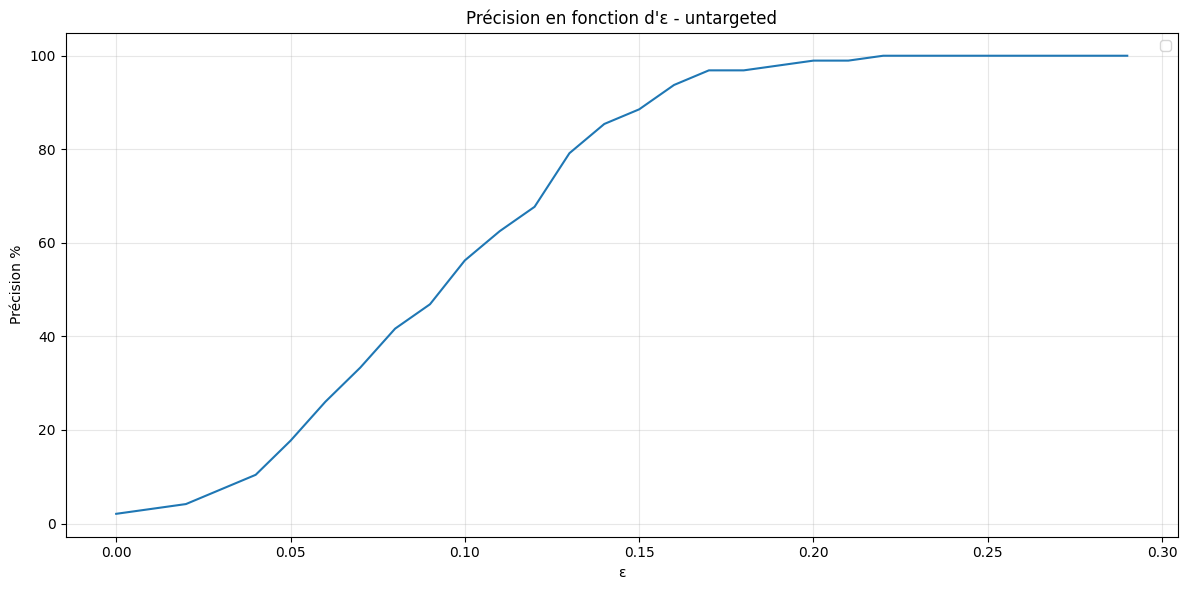

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(epsilon_vals, accuracy)
plt.title("Précision en fonction d'ε - untargeted")
plt.xlabel("ε")
plt.ylabel("Précision %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
print(accuracy)

[2.0833333333333286, 3.125, 4.166666666666671, 7.291666666666671, 10.416666666666671, 17.70833333333333, 26.04166666666667, 33.33333333333333, 41.666666666666664, 46.875, 56.25, 62.5, 67.70833333333334, 79.16666666666667, 85.41666666666667, 88.54166666666667, 93.75, 96.875, 96.875, 97.91666666666667, 98.95833333333333, 98.95833333333333, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


### Quels chiffre est le plus facilement attaquable ?

In [12]:
epsilon_vals = []
accuracies = [[] for _ in range(10)]  #une liste par classe

for epsilon in range(0, 20, 1):
    total_per_class   = [0] * 10
    correct_per_class = [0] * 10
    
    for images, labels in normal_loader:
        attack_images = fgsm_attack(model, loss_fn, images, labels, epsilon/100)
        outputs = model(attack_images)
        
        predictions = np.argmax(outputs, axis=1)
        true_labels = np.argmax(labels , axis=1)
        
        # accuracy pour chaque classe
        for pred, true_label in zip(predictions, true_labels):
            total_per_class[true_label] += 1
            if pred == true_label: correct_per_class[true_label] += 1
    
    epsilon_vals.append(epsilon*.01)
    
    # stocker
    for class_idx in range(10):
        if total_per_class[class_idx] > 0:
            accuracy = 100 - 100 * correct_per_class[class_idx] / total_per_class[class_idx]
        else:
            accuracy = 0
        accuracies[class_idx].append(accuracy) 

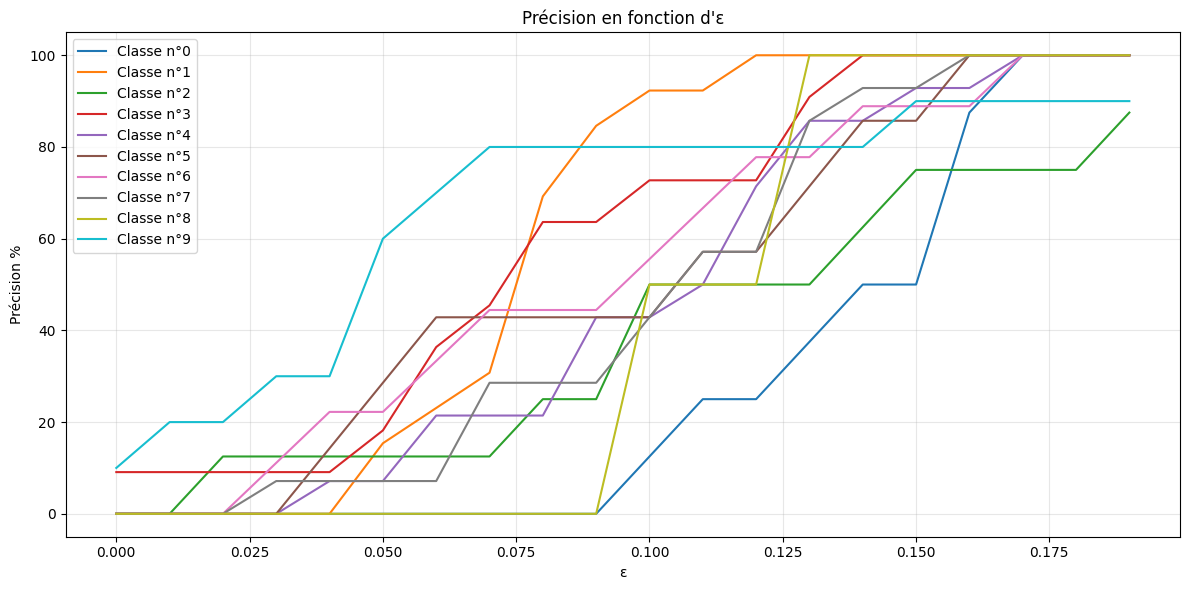

In [13]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(epsilon_vals, accuracies[i], label=f'Classe n°{i}')
plt.title("Précision en fonction d'ε")
plt.xlabel("ε")
plt.ylabel("Précision %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


On remarque que la classe 0 est celle qui est la plus résistante aux attaques tandis que la classe 9 est la moins résistante.

## Attaques targeted

In [14]:
def fgsm_attack_targeted(model, loss_fn, images, labels, target_class, epsilon):
    with tf.device(f'/{device}:0'):
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        
        # creer les labels
        target_labels = tf.one_hot(target_class, 10)
        target_labels = tf.tile(tf.expand_dims(target_labels, 0), [tf.shape(images)[0], 1])
        target_labels = tf.cast(target_labels, tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(images)
            outputs = model(images)
            # minimiser le loss de la class target
            cost = loss_fn(target_labels, outputs)
        
        gradients = tape.gradient(cost, images)
        # on soustrait plutot qu'additionner car on cherche a diminuer le loss
        attack_images = images - epsilon * tf.sign(gradients)
        attack_images = tf.clip_by_value(attack_images, 0, 1) # np.clip
        
        return attack_images.numpy()


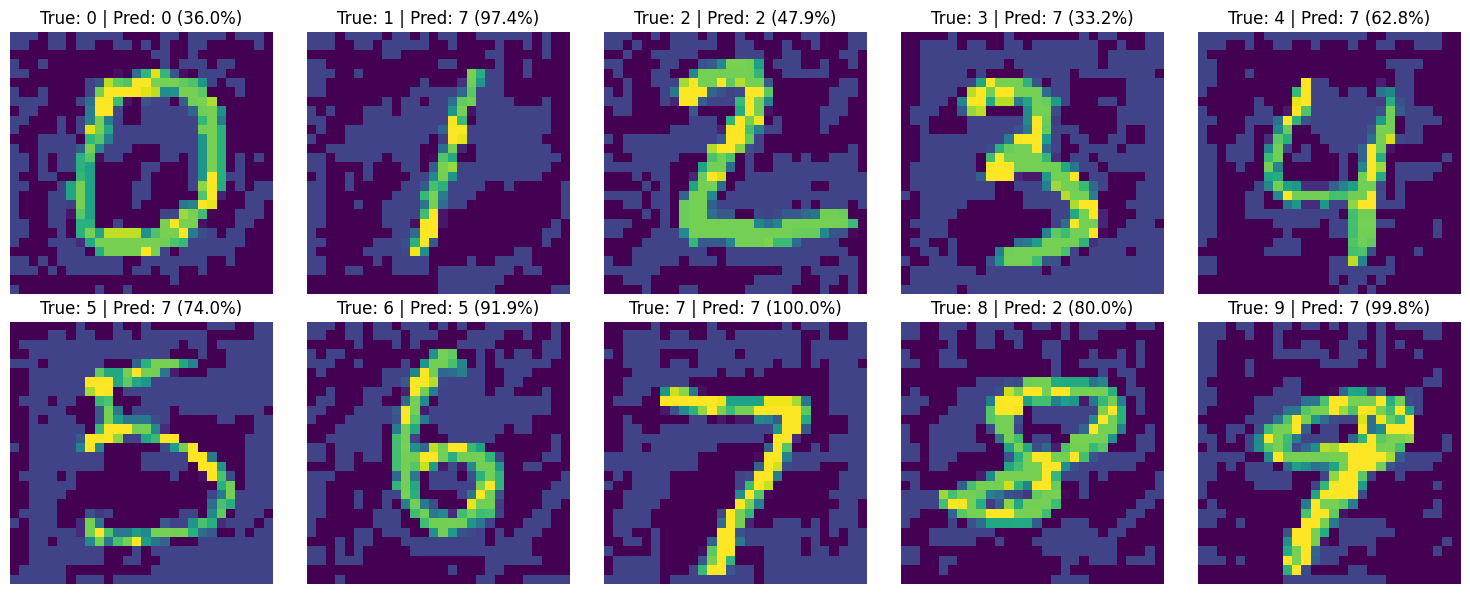

Targeted Attack - Epsilon: 0.2, Target Class: 7, Success Rate: 60.42%


In [15]:
epsilon = 0.20
target_class = 7
correct_targeted = 0
total = 0
adv_images_list = []
predictions_list = []
confidences_list = []
true_labels_list = []

for images, labels in normal_loader:
    attack_images = fgsm_attack_targeted(model, loss_fn, images, labels, target_class, epsilon)
    outputs = model(attack_images)
    predictions = np.argmax(outputs, axis=1)
    confidences = np.max(outputs, axis=1) * 100
    true_labels = np.argmax(labels, axis=1)
    
    total += len(labels)
    correct_targeted += np.sum(predictions == target_class)
    
    # stocker pour l'affichage
    adv_images_list .extend(attack_images)
    predictions_list.extend(predictions)
    confidences_list.extend(confidences)
    true_labels_list.extend(true_labels)


display_images = [  adv_images_list[10], # 0
                    adv_images_list[2], # 1
                    adv_images_list[1], # 2
                    adv_images_list[32], # 3
                    adv_images_list[4], # 4
                    adv_images_list[15], # 5
                    adv_images_list[21], # 6
                    adv_images_list[0], # 7
                    adv_images_list[61], # 8
                    adv_images_list[9]] # 9


display_confidences = [confidences_list[10],
                       confidences_list[2],
                       confidences_list[1],
                       confidences_list[32],
                       confidences_list[4],
                       confidences_list[15],
                       confidences_list[21],
                       confidences_list[0],
                       confidences_list[61],
                       confidences_list[9]]

display_predictions = [predictions_list[10],
                       predictions_list[2],
                       predictions_list[1],
                       predictions_list[32],
                       predictions_list[4],
                       predictions_list[15],
                       predictions_list[21],
                       predictions_list[0],
                       predictions_list[61],
                       predictions_list[9]]


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(display_images[i].reshape(28, 28))
    axes[i].set_title(f'True: {i} | Pred: {display_predictions[i]} ({display_confidences[i]:.1f}%)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

accuracy = 100 * float(correct_targeted) / total
print(f'Targeted Attack - Epsilon: {epsilon}, Target Class: {target_class}, Success Rate: {accuracy:.2f}%')

### Vers quel chiffre est-ce le plus facile de tromper le modèle ?

In [16]:
def accuracy_per_class(i):
    epsilon_vals=[]
    accuracy=[]
    for epsilon in range(30):

        real_epsilon = epsilon/100
        
        target_class = i
        correct_targeted = 0
        total = 0

        for images, labels in normal_loader:
            attack_images = fgsm_attack_targeted(model, loss_fn, images, labels, target_class, real_epsilon)
            outputs = model(attack_images)
            predictions = np.argmax(outputs, axis=1)
            
            total += len(labels)
            correct_targeted += np.sum(predictions == target_class)
          
            
        epsilon_vals.append(real_epsilon)
        accuracy.append(100*correct_targeted/total)
    return epsilon_vals, accuracy

In [17]:
results = []
for i in range(10):
    print(i, end=" ", flush=True)
    epsilon_vals, accuracy = accuracy_per_class(i)
    results.append(accuracy)

0 1 2 3 4 5 6 7 8 9 

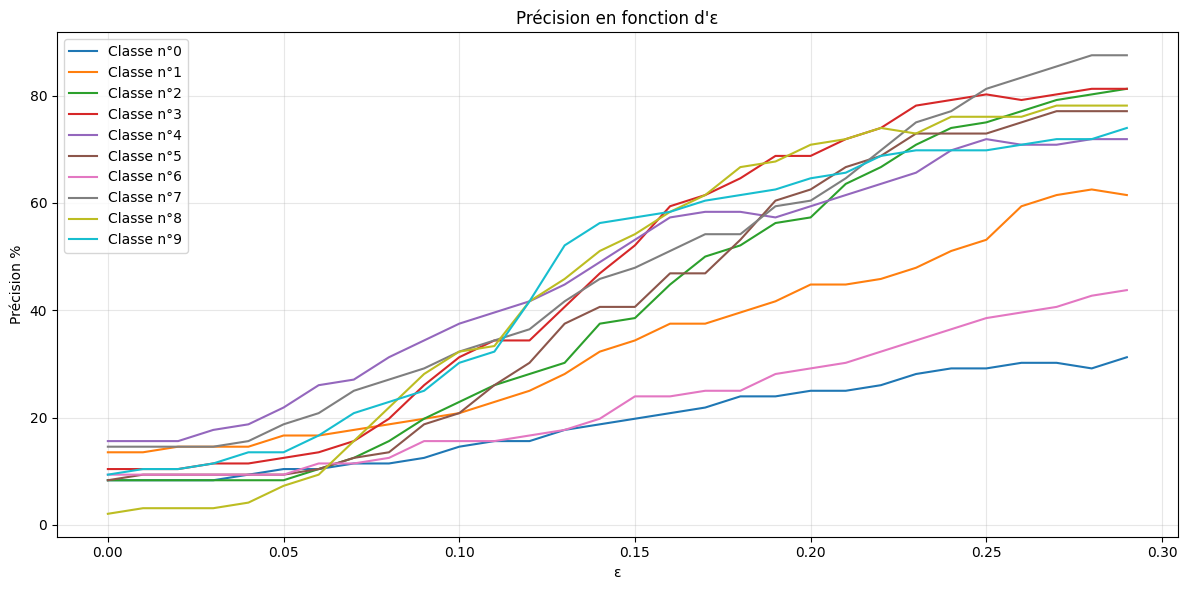

In [18]:
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.plot(epsilon_vals, results[i], label=f'Classe n°{i}')
plt.title("Précision en fonction d'ε")
plt.xlabel("ε")
plt.ylabel("Précision %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

On remarque que c'est plus facile de transformer une image pour trick le modèle à penser que c'est un 3 ou un 7 que de lui faire penser que c'est un 0 ou un 8. (formes circulaires: plus galère ?)

In [19]:
def avg(l):
    s = 0
    for i in l:
        s+=i
    return s/len(l)

In [20]:
accuracy = [0 for _ in range(len(results[0]))]
for i in range(len(results[0])):
    accuracy[i] = avg([results[k][i] for k in range(len(results))])


/tmp/ipykernel_259/1270977665.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


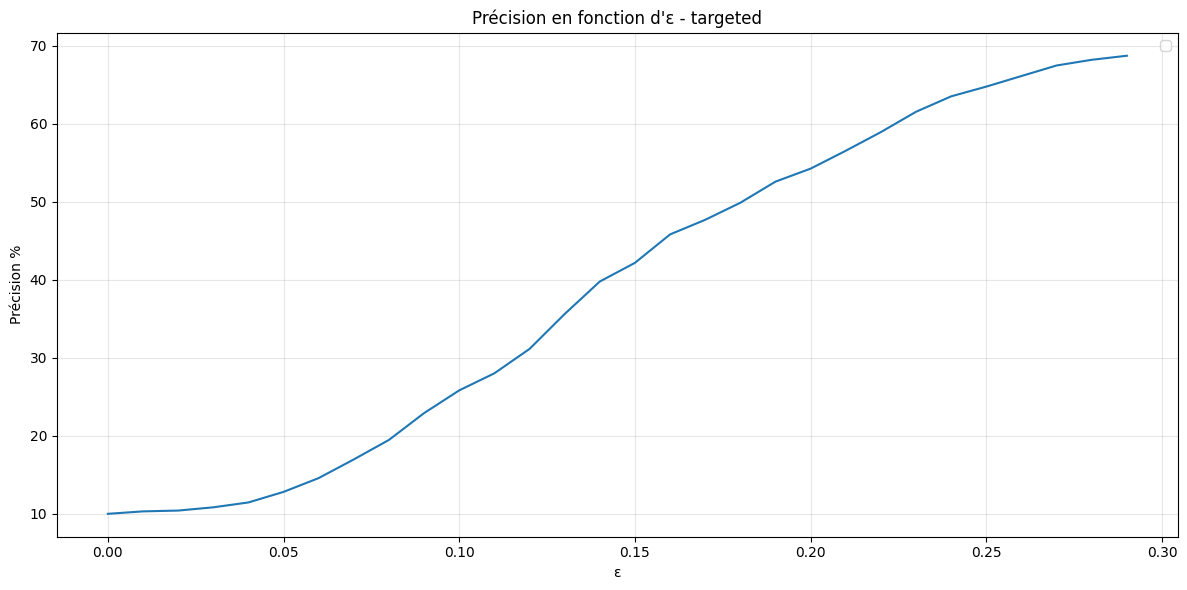

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(epsilon_vals, accuracy)
plt.title("Précision en fonction d'ε - targeted")
plt.xlabel("ε")
plt.ylabel("Précision %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
print(accuracy)

[9.999999999999998, 10.3125, 10.416666666666666, 10.833333333333332, 11.458333333333334, 12.8125, 14.583333333333332, 16.979166666666664, 19.479166666666664, 22.916666666666664, 25.833333333333332, 28.020833333333336, 31.145833333333336, 35.62499999999999, 39.79166666666667, 42.18750000000001, 45.83333333333333, 47.708333333333336, 49.89583333333333, 52.604166666666664, 54.270833333333336, 56.5625, 58.958333333333336, 61.5625, 63.541666666666664, 64.79166666666666, 66.14583333333333, 67.5, 68.22916666666666, 68.75000000000001]


## Creation d'un graphique de comparaison de précision

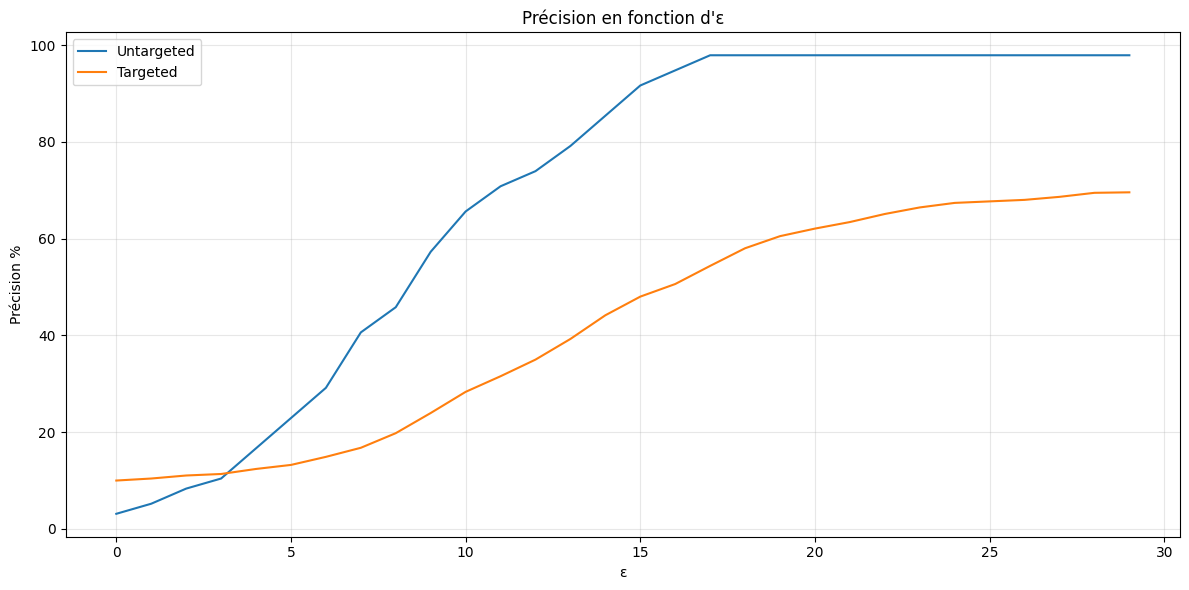

In [23]:
accuracy_untargeted= [3.125, 5.208333333333329, 8.333333333333329, 10.416666666666671, 16.66666666666667, 22.91666666666667, 29.16666666666667, 40.625, 45.833333333333336, 57.291666666666664, 65.625, 70.83333333333333, 73.95833333333333, 79.16666666666667, 85.41666666666667, 91.66666666666667, 94.79166666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667, 97.91666666666667]
accuracy_targeted  = [9.999999999999998, 10.416666666666666, 11.041666666666668, 11.354166666666668, 12.395833333333334, 13.229166666666668, 14.895833333333334, 16.770833333333332, 19.791666666666668, 23.958333333333332, 28.333333333333332, 31.5625, 35.00000000000001, 39.27083333333333, 44.16666666666667, 48.02083333333333, 50.62500000000001, 54.375, 58.02083333333335, 60.520833333333336, 62.083333333333336, 63.4375, 65.10416666666666, 66.45833333333333, 67.39583333333334, 67.70833333333333, 68.02083333333333, 68.64583333333334, 69.47916666666667, 69.58333333333334]
epsilon_vals = [e for e in range(30)]

plt.figure(figsize=(12, 6))
plt.plot(epsilon_vals, accuracy_untargeted, label="Untargeted")
plt.plot(epsilon_vals, accuracy_targeted, label="Targeted")
plt.title("Précision en fonction d'ε")
plt.xlabel("ε")
plt.ylabel("Précision %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()